# Convolutional Neural Networks

* Author: Johannes Maucher
* Last Update: 30.10.2020

There exists different types of deep neural networks, e.g.
* Convolutional Neural Networks (CNNs)
* Deep Belief Networks (DBNs)
* Stacked Autoencoders
* (Hierarchical) Recurrent Networks
* (Hierarchical) Attention Networks
* Sequence-to-Sequence Networks
* Transformer Networks
* Deep Q-Networks (Deep Reinforcementlearning)
* Generative Adversarial Networks

and many variants of them. 

Among these different types, CNNs are currently the most relevant ones. This notebook describes the overall architecture and the different layer-types, applied in a CNN. Since the most prominent application of CNNs is object recognition in images, the descriptions in this notebook refer to this use-case. 

## Overall Architecture


On an abstract level the architecture of a Deep Neural Network looks like this:

<img src="https://maucher.home.hdm-stuttgart.de/Pics/dnnExtractorClassifier.png" alt="Drawing" style="width: 800px;"/>

The goal of deep learning is to extract meaningful features. The *Extractor-Part* of the network learns from low-level features (e.g. pixel values) at the input of the network a hierarchy of increasingly meaningful features. Using informative features a classifier at the end of the Deep Neural Network can easily determine the correct class (see also the sketch below and the [cat-example-image](#cnnconceptcat)). 

**Example:** Four different types of feature-representations to be used as input for a classifier, which shall be able to detect houses and cars:

<img src="https://maucher.home.hdm-stuttgart.de/Pics/betterFeatures.png"> 

**Visualization of learned features**

Source: [Zeiler and Fergus: Visualizing and Understanding of Convolutional Neural Networks](https://arxiv.org/pdf/1311.2901.pdf)

Learned features in layers 1 and 2:
<img src="https://maucher.home.hdm-stuttgart.de/Pics/zeilerLayers1-2.PNG">

Learned features in layer 3:
<img src="https://maucher.home.hdm-stuttgart.de/Pics/zeilerLayer3.PNG"> 

Learned features in layers 4 and 5:
<img src="https://maucher.home.hdm-stuttgart.de/Pics/zeilerLayers4-5.PNG"> 

The picture below contains a very famous CNN - the so called [AlexNet](https://www.nvidia.cn/content/tesla/pdf/machine-learning/imagenet-classification-with-deep-convolutional-nn.pdf), which won the ImageNet contest in 2012. In the classification-task of this contest 1000 different objects must be recognized in images. For training 15 million labeled images have been applied. On a computer with two GTX 580 3GB GPUs training took about 6 days. AlexNet achieved a top-5 error rate of 15.4% - compared to 26.2% of the second best. AlexNet can be considered as an important milestone in the development and application of deep neural networks.
<a id="alexnet"></a>
<img src="https://maucher.home.hdm-stuttgart.de/Pics/AlexNetArchitecture.png" width="800" align="center">

The input of to the AlexNet is a 3-channel RGB-image. The dense-layer at the output consists of 1000 neurons, each refering to one of the 1000 object categories, which are distinguished in the ImageNet data. The index of the output-neuron with the maximum value indicates the most-probable object category. 

Between input- and output-layer, there are basically three different types of layers:
* convolutional layers
* pooling layers
* fully connected layers

Moreover, normalisation-layers, dropout-layers, deconvolution-layers and dilation-layers are also frequently applied in CNNs. In the following sections, these layer types are described.

In [1]:
%matplotlib inline
import scipy.ndimage as ndi
import numpy as np
np.set_printoptions(suppress=True)
from matplotlib import pyplot as plt
import matplotlib.cm as cm
grays=plt.get_cmap('gray')
np.set_printoptions(precision=2)

## Convolution Layer

A key concept of CNNs is the convolutional layer type. This layer type applies convolutional filtering, which is a well known image processing (or more general: signal processing) technique to extract features from the given input. In contrast to conventional convolutional filtering, in CNNs the filter coefficients and thus the relevant features are **learned**. In this section first the concept of conventional convolutional filtering is described. Then subsection [Convolutional Layer in CNNs](#convLayer) discusses the application of this concept in CNNs.

<a id="conceptConvolution"></a>
### Concept of 2D-Convolution Filtering

Convolution Filtering of a 2D-Input of size 

$$
(r \times c)
$$ 

with a 2D-Filter of size 

$$
(a \times b)
$$

is defined by applying the filter at each possible position and calculating the scalar product of the filter coefficients and the input-values covered by the current position of the filter. This scalar product is the filter-output at the corresponding position. 
If the filter is applied with a stepsize of $s=1$, then there exists $(r-a+1) \times (c-b+1)$ possible positions for calculating the scalar product. Hence, the output of the convolution filtering is of size 

$$
(r-a+1) \times (c-b+1).
$$

Hereafter, we assume to have quadratic inputs of size $(r \times r)$ and quadratic filters of size $(a \times a)$. 

The picture below shows the filtering of a $(10 \times 10)$ input with an average filter of size $(3 \times 3)$. In this picture the filtering operation is only shown for the upper right and the lower left position. Actually, there are $(8 \times 8)$ elements in the output.

> **Note:** In signal processing convolution and correlation is not the same. Convolution is correlation with the filter rotated 180 degrees. In context of neural networks, where filter coefficients are learned, this distinction can be ignored. As it is common in machine learning literature, in this notebook convolution and correlation are the same.

<img src="https://maucher.home.hdm-stuttgart.de/Pics/ConvolutionConceptSmall.png" width="600" align="center">

#### Stepsize
The filter need not be convolved in steps of $s=1$ across the input. Larger stepsizes yield a correspondingly smaller output. In the picture below filtering with stepsize of $s=2$ is shown below filtering the same input with a stepsize of $s=1$. 

<img src="https://maucher.home.hdm-stuttgart.de/Pics/ConvStepSizeSmall.png" width="600" align="center">



#### Zero-Padding
Besides stepsize, *Padding* is an important parameter of convolutional filtering. A padding of $p>0$ means, that at the left, right, upper and lower boundary of the input $p$ columns (rows) of zeros are attached to the input. In the picture below a padding of $p=1$ (lower part) is compared with a convolutional filtering without padding (upper part).
Often zero-padding is set such that the size of output is equal to the size of the input. For a stepsize of $s=1$ and an uneven filter-width of $a$, this is the case if

$$
p=\frac{a-1}{2}
$$

<img src="https://maucher.home.hdm-stuttgart.de/Pics/ConvPaddingSmall.png" width="600" align="center">


For a quadratic input with sidelength `r`, a quadratic filter of side-length `a`,  a padding of `p`, and a stepsize of `s`, the quadratic output of convolution-filtering has a side-length of 

$$
o=\frac{r-a+2p}{s}+1.
$$

<img src="http://maucher.home.hdm-stuttgart.de/Pics/ConvolutionFilterDemo3.gif" style="width:800px" align="center">

#### Example: 2D-convolution filter 

Below, a 2D input `x1` of shape (10,10) is defined as a numpy-array. The signal values are `1` (white) in the (4,4)-center region and `0` (black) elsewhere. For the display of the 2-dimensional signal the matplotlib method imshow() is applied.

In [2]:
x1=np.zeros((10,10))
x1[3:7,3:7]=1
print(x1)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


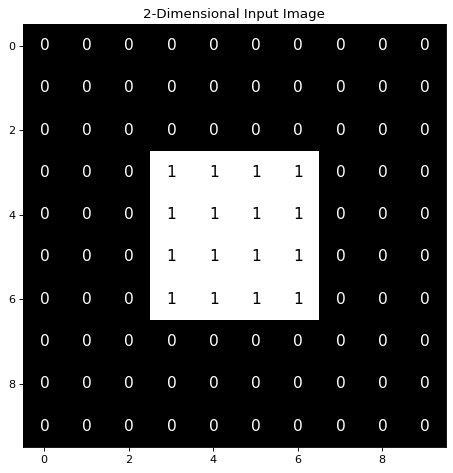

In [3]:
offt=1
offx=1
dx=0.1
dy=0.1
usecols=["white","black"]
plt.figure(num=None, figsize=(14,7), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(x1,cmap=plt.cm.gray,interpolation='none')
for col in range(10):
    for row in range(10):
        number="%d"%x1[row,col]
        plt.text(col-dx,row+dy,number,fontsize=14,
                 color=grays(1-x1[row,col]))
plt.title('2-Dimensional Input Image')
plt.show()

A 2-dimensional **average-filter** shall be applied on this image. We implement this filter as a numpy-array: 

In [4]:
FSIZE=3
avgFilter=1.0/FSIZE**2*np.ones((FSIZE,FSIZE))
print("Coefficients of average filter:\n",avgFilter)

Coefficients of average filter:
 [[0.11 0.11 0.11]
 [0.11 0.11 0.11]
 [0.11 0.11 0.11]]


The filtering operation is performed in the following code cell. Note, that the `correlate()` function applies filtering with **zero-padding** of size $$p=\frac{a-1}{2}$$.

In [5]:
avgImg=ndi.correlate(x1,avgFilter, output=np.float64, mode='constant')
#print "Result of average filtering:\n",avgImg

The filter result as calculated above, is visualized in the code-cell below:

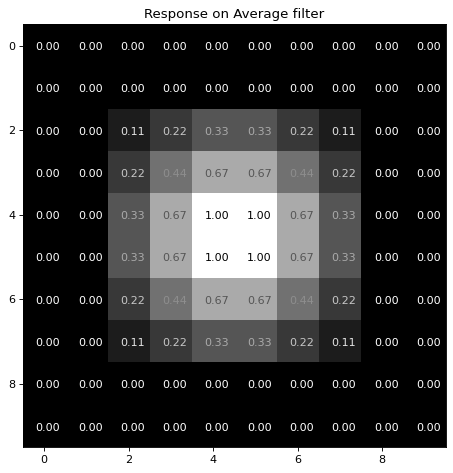

In [6]:
dx=0.2
plt.figure(num=None, figsize=(14,7), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(avgImg,cmap=plt.cm.gray,interpolation='none')
for col in range(10):
    for row in range(10):
        number="%1.2f"%avgImg[row,col]
        plt.text(col-dx,row+dy,number,fontsize=10,
                 color=grays(1-avgImg[row,col]))
plt.title('Response on Average filter')
plt.show()

#### Example: Gradient Filters for Edge Detection
A 2-dimensional filter, which calculates the gradient in x-direction can be implemented as 2-dimensional numpy-array: 

In [7]:
gradx=np.array([[-1.0, 0.0, 1.0],[-1.0, 0.0, 1.0],[-1.0, 0.0, 1.0],])
print(gradx)

[[-1.  0.  1.]
 [-1.  0.  1.]
 [-1.  0.  1.]]


The filter defined above is the well known [Prewitt Filter](https://de.wikipedia.org/wiki/Prewitt-Operator), which is frequently applied for edge-detection. The response of this filter applied to our example image can be calculated as follows:

In [8]:
gradxImg=ndi.correlate(x1,gradx, output=np.float64, mode='constant')
#print "Result of x-gradient Filtering:\n",gradxImg

Visualization of the Prewitt-x-gradient calculation: 

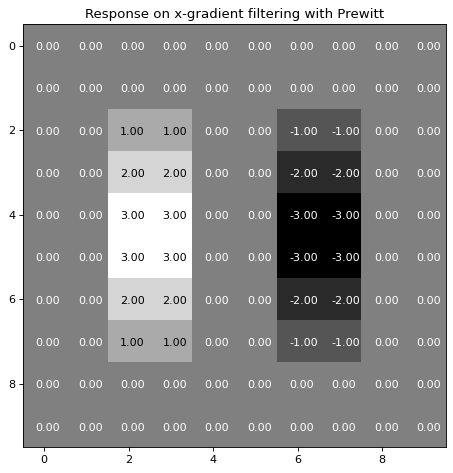

In [9]:
dx=0.2
plt.figure(num=None, figsize=(14,7), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(gradxImg,cmap=plt.cm.gray,interpolation='none')
for col in range(10):
    for row in range(10):
        number="%1.2f"%gradxImg[row,col]
        plt.text(col-dx,row+dy,number,fontsize=10,
                 color=grays(1-gradxImg[row,col]))
plt.title('Response on x-gradient filtering with Prewitt')
plt.show()

For determining the gradient in y-direction the Prewitt filter for the x-gradient must just be transposed:

In [10]:
grady=np.transpose(gradx)
print(grady)

[[-1. -1. -1.]
 [ 0.  0.  0.]
 [ 1.  1.  1.]]


The response of this y-gradient prewitt filter applied to our example image can be calculated and visualized as follows:

In [11]:
gradyImg=ndi.correlate(x1,grady, output=np.float64, mode='constant')
#print "Result of y-gradient Filtering:\n",gradyImg

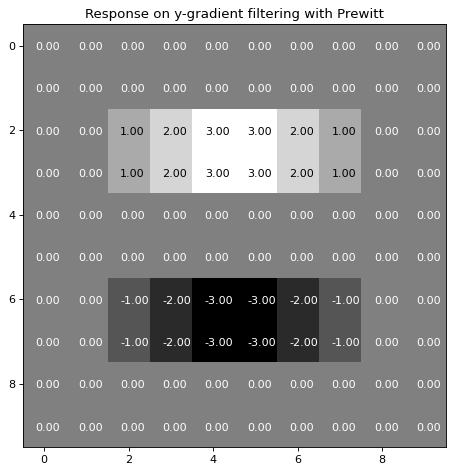

In [12]:
dx=0.2
plt.figure(num=None, figsize=(14,7), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(gradyImg,cmap=plt.cm.gray,interpolation='none')
for col in range(10):
    for row in range(10):
        number="%1.2f"%gradyImg[row,col]
        plt.text(col-dx,row+dy,number,fontsize=10,
                 color=grays(1-gradyImg[row,col]))
plt.title('Response on y-gradient filtering with Prewitt')
plt.show()

#### Applying the Prewitt filter for detecting horizontal and vertical edges in an image

In the previous subsection the Prewitt filter has been applied on a small 2D-input. Now, both filters are applied to the real image. The real greyscale image, it's gradients in x- and y-direction and the magnitude of the gradient are plotted below: 

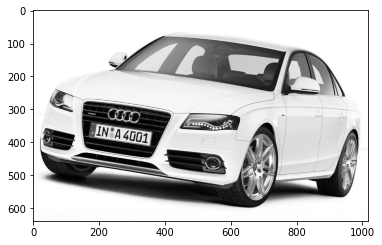

In [13]:
from PIL import Image
im = np.array(Image.open("../Data/a4weiss.jpg").convert('L'))
plt.imshow(im,cmap='Greys_r')

In [14]:
imx=ndi.correlate(im,gradx, output=np.float64, mode='constant')
imy=ndi.correlate(im,grady, output=np.float64, mode='constant')

The output of the Prewitt filter is stored in the numpy arrays imx and imy, respectively. Moreover, the magnitude of the gradient is calculated and plotted to the matplotlib figure.

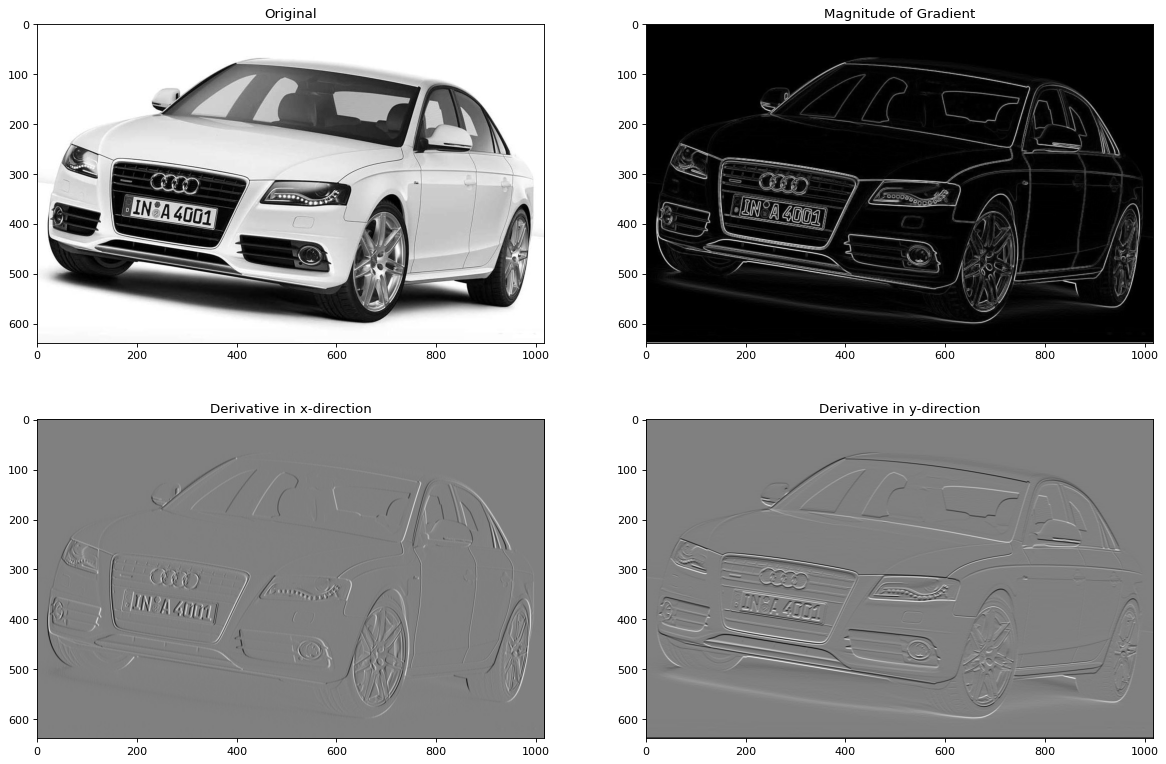

In [15]:
magnitude=np.sqrt(imx**2+imy**2)
plt.figure(num=None, figsize=(18,12), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(2,2,1)
plt.imshow(im,cmap=plt.cm.gray)
plt.title("Original")
plt.subplot(2,2,2)
plt.imshow(magnitude,cmap=plt.cm.gray)
plt.title("Magnitude of Gradient")
plt.subplot(2,2,3)
plt.imshow(imx,cmap=plt.cm.gray)
plt.title('Derivative in x-direction')
plt.subplot(2,2,4)
plt.title('Derivative in y-direction')
plt.imshow(imy,cmap=plt.cm.gray)
plt.show()

<a id="convLayer"></a>
### Convolutional Layer in CNNs

In the car-image example above 3 different filters where applied on a single input. Each filter extracted a specific feature: 
* the x-component of the gradient,
* the y-component of the gradient,
* the magnitude of the gradient.


In Convolutional Neural Networks (CNN) the concept of convolution-filtering is realized as demonstrated above. However, in CNNs
* the filter coefficients are not defined by the user. Instead they are **learned in the training phase**, such that these filters are able to detect patterns, which frequently occur in the training data. In the context of CNNs the filter-coefficients are called **weights**.
* the output of a convolutional filter is called a **feature map**. All elements of a single feature map are calculated by the same set of **shared weights**.
* the output-elements of a convolutional filter are typically fed element-wise to an **activation-function**, which maps single scalars to other scalars. 
* for a given input not only one, but **multiple feature maps** are calculated in parallel. Different feature maps have different sets of **shared weights**. In the car-image above, three different filters calculated 3 different feature maps on a single input.
* The input does not only contain one, but multiple parallel 2D arrays of equal size. These parallel 2D-arrays are called **channels**.


#### Dense Layer
In conventional neural networks (Multi Layer Perceptron) each layer is a so called *Dense Layer* as depicted in the image below: 
<img src="https://maucher.home.hdm-stuttgart.de/Pics/denseLayerTikz.png" style="width: 600px" />

#### Simple Convolutional Layer 1-Dimensional
A single feature map calculated from a single channel in a 1-dimensional convolutional layer is shown below:

<img src="https://maucher.home.hdm-stuttgart.de/Pics/convLayer1DTikz.png" style="width: 600px" />

#### Simple Convolutional Layer 2-Dimensional
A single feature map calculated from a single channel in a 2-dimensional convolutional layer is shown below:

<img src="https://maucher.home.hdm-stuttgart.de/Pics/convLayer2DTikz.png" style="width: 600px" />

In the sequel, neurons and weights in convolutional layers are represented as 2-dimensional arrays. The picture below represents the same operation as the picture above.

<img src="https://maucher.home.hdm-stuttgart.de/Pics/convLayer2DarrayTikz.png" style="width: 500px" />

<a id="multichannels"></a>
#### Multiple Channels at the input of the Convolutional Layer
In CNNs the input to a convolutional layer is in general not a single 2D-array, but a set of multiple arrays (channels). For example in object recognition the input of the first convolutional layer $conv_1$ is usually the image. The number of channels is then 3 for a RGB-image and 1 for a greyscale image. For all of the following convolutional layers $conv_i, \; i>1,$ the input is typically the set of (pooled) feature maps of the previous layer $conv_{i-1}$. In the picture below the calculation of the values of a single feature map from $L=3$ channels at the input of the convolutional layer is depicted. Note that for calculating the values of a single feature map, for each channel an individual filter is learned and applied. 



<img src="https://maucher.home.hdm-stuttgart.de/Pics/ConvolutionMultChan.png" width="500" align="center">


<a id="multifeatures"></a>
#### Multiple Feature Maps at the output of the Convolutional Layer
The previous subsection demonstrated the calulation of a single feature map from multiple channels at the input of the convolutional layer. **In a CNN there are multiple channels at the input and multiple feature maps at the output of a convolutional layer.** For sake of simplicity - and because we already know how multiple channels at the input influence a single feature map at the output - the picture and the code cells below demonstrate how multiple feature maps at the output are calculated from a single channel. Note that each feature map has it's own set of shared weights (filter-coeffients) for each channel at the input of the convolutional layer:

<img src="https://maucher.home.hdm-stuttgart.de/Pics/ConvolutionMultFeats.png" width="500" align="center">



### Activation function
Activation functions operate element-wise on the values of feature maps. The most common activation functions are 
* ReLU (Rectified Linear Unit)
* sigmoid
* tanh (tangens hyperbolicus)
* linear
* softmax
* threshold
These functions are defined and visualized below.

In [16]:
def sigmoid(input):
    return 1/(1+np.exp(-input))

In [17]:
def tanh(input):
    return np.tanh(input)

In [18]:
def linear(input):
    return input

In [19]:
def relu(input):
    return np.maximum(np.zeros(input.shape),input)

In [20]:
def softmax(z):
    """Softmax activation function."""
    return np.exp(z)/np.sum(np.exp(z),axis=0)

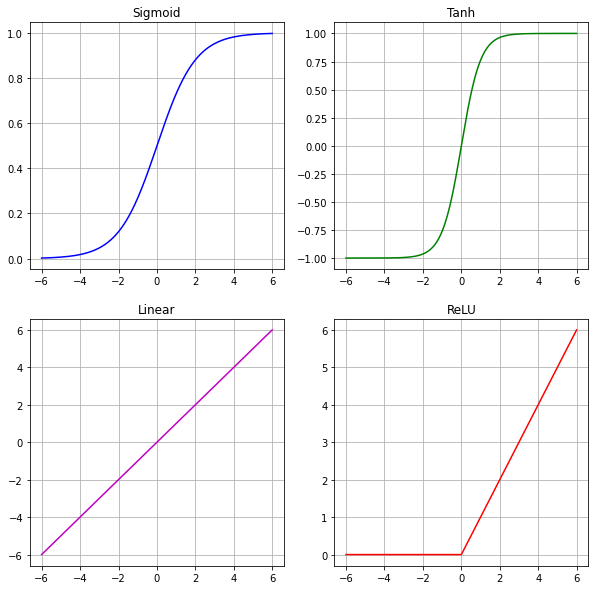

In [21]:
R=6
x=np.arange(-R,R,0.01)
plt.figure(figsize=(10,10))
###Sigmoid#################
plt.subplot(2,2,1)
plt.grid()
ysig=sigmoid(x)
plt.plot(x,ysig,'b-')
plt.title("Sigmoid")
###Tanh####################
plt.subplot(2,2,2)
plt.grid()
ytan=tanh(x)
plt.plot(x,ytan,'g-')
plt.title("Tanh")
###Linear##################
ylin=linear(x)
plt.subplot(2,2,3)
plt.grid()
plt.plot(x,ylin,'m-')
plt.title("Linear")
###Relu####################
yrelu=relu(x)
plt.subplot(2,2,4)
plt.grid()
plt.plot(x,yrelu,'r-')
plt.title("ReLU")
plt.show()

## Pooling Layer in CNNs
Convolutional layers extract spatial features from their input. The filters (sets of shared weights) define which features are extracted. In the training phase the filters are learned, such that after learning they represent patterns, which frequently appear in the training data. Since each element in a feature map corresponds to a unique region of the input, feature maps do not only represent if the feature is contained in the current input, but also where it is contained (spatial information). 

The benefits of **pooling layers** are:
* they reduce the size of the input channels and therefore reduce complexity
* they provide a certain degree of shift-invariance in the sense, that if in two inputs a certain feature appears not in exactly the same position, but in nearby positions they yield the same pooled output.

Similar as in a convolution layer, in pooling layers a filter is shifted across a 2D-input and calculates for each position a single value. However, in pooling layers
* the filter weights are not learned, instead the operation performed is a fixed and often non-linear operation. Common pooling operations are:
    * **max-pooling**: the filter outputs the maximum of it's current input region
    * **min-pooling**: the filter outputs the minimum of it's current input region
    * **mean-pooling**: the filter outputs the arithmetic mean of it's current input region
  
  The most frequent type is max-pooling.
  
* the common stepsize $s$ in a pooling layer is equal to the width of the filter $w$, i.e. the pooling filter operates on *non-overlapping* regions. Even though $s=w$ is the common configuration, it is not mandatory and there exist some good CNNs, whose pooling layers operate in a overlapping manner with $s<w$. 

In the picture below max-pooling with a filter width of $w=s=2$ is shown. In this case pooling reduces the size of the 2D-input by a factor of 2. 


<img src="https://maucher.home.hdm-stuttgart.de/Pics/MaxPooling.png" width="600" align="center">


The configuration sketched in the picture above is implemented in the code cells below.

## Concatenation of Convolution and Pooling

As shown by the example of the [AlexNet architecture](#alexnet), in a CNN after the input layer usually a cascade of convolution followed by pooling is applied. Each convolutional layer extracts meaningful features and their location. Each pooling layer reduces the size of the channels and thus the spatial resolution of features. 

The image below shows a single sequence of convolution and pooling.   

<a id="convrelupool"></a>
<img src="https://maucher.home.hdm-stuttgart.de/Pics/ConvActPool.png" width="700" align="center">

In subsections [Multiple Channels](#multichannels) and [Multiple Feature Maps](#multifeatures) it was already shown how to calculate a single feature map from multiple input channels and how to calculate multiple feature maps from a single input channel. Now, we have a combination of both of them: Multiple feature maps are calculated from multiple channels. For a convolutional Layer with $C$ input channels and $F$ feature maps at the output, the entire operation is defined by an array of $F$ rows and $C$ columns. Each element of this array is a 2-dim array $W_{ij}$, which is the filter applied for calculating feature map $i$ from channel $j$. Hence, the **entire convolutional operation** is defined by a **4-dim filter array**, whose

* first dimension is the number of featuremaps $F$ at the output of the convolutional layer
* second dimension is the number of channels $C$ at the input of the convolutional layer 
* third and forth dimension is given by the size of the covolutional filter $W_{ij}$.

Correspondingly, the $C$ input channels can be arranged in a **3-dimensional input array**, whose

* first dimension is the number of channels $C$ at the input of the convolutional layer
* second dimension is the number of rows in each input channel
* third dimension is the number of columns in each input channel

Applying the 4-dimensional filter array on the 3-dimensional input array yields a **3-dimensional feature array**, whose 

* first dimension is the number of featuremaps $F$ in the output of the convolutional layer
* second dimension is the number of rows in each featuremap at the output of the convolutional layer
* third dimension is the number of columns in each featuremap at the output of the convolutional layer


The picture below sketches the sequence of convolution, activation and pooling in an abstract manner: For $L_i$ input channels of convolutional layer $conv_i$ $L_{i+1}$ feature maps are calculated. These feature maps are processed by an activation function and fed to a pooling layer. The pooled $L_{i+1}$ feature maps are the $L_{i+1}$ input channel for the next convolutional layer. If no further convolution-layer is applied, the pooled feature maps are serialized and fed to a fully connected layer. 

<img src="https://maucher.home.hdm-stuttgart.de/Pics/ChannelCubes.png" width="400" align="center">

## Fully Connected Layers
In CNNs cascades of convolution- and pooling layer learn to extract meaningful features. These learned features are then fed to a classifier or to a regressor, which outputs the estimated class or the estimated numeric value, respectively. The final classifier or regressor is usually implemented by a usual single- or multilayer perceptron (SLP or MLP). The layers of the SLP or MLP are called **fully connected layers**, since each neuron in layer $k$ is connected to all neurons in layer $k-1$.

If $\mathbf{x}=(x_1,x_2,\ldots,x_n)$ is the input and $\mathbf{y}=(y_1,y_2,\ldots,y_m)$ is the output of a fully connected layer, then 

$$\mathbf{y}=g(W \cdot \mathbf{x^T}),$$

where $g()$ is the activation function and 

$$W=\left(
		\begin{array}{cccc}
		w_{1,1} & w_{1,2} & \cdots & w_{1,16}  \\ 
		w_{2,1} & w_{2,2} & \cdots & w_{2,16}  \\ 
        \vdots &  \vdots  & \ddots & \vdots  \\
		w_{8,1} & w_{8,2} & \cdots & w_{8,16}  \\ 
		\end{array}
		\right)$$

is the weight matrix. Entry $w_{i,j}$ is the weight from the $j.th$ element in $\mathbf{x}$ to the $i.th$ element in $\mathbf{y}$.

As shown in the picture below, the output of the last pooling layer is serialized before it is fed into a fully connected layer. In this example only one fully connected layer is applied, i.e. the classifier is just a SLP. Since there are 8 neurons in the output of the fully connected layer, this example architecture can be applied for a classification into 8 classes. In this case the output is usually processed by a **softmax-activation function**, which is not depicted in the image below. 

<img src="https://maucher.home.hdm-stuttgart.de/Pics/ConvActPoolFC.png" width="800" align="center">

<a id='cnnconceptcat'></a>
### CNN Summary
<img src="https://maucher.home.hdm-stuttgart.de/Pics/cnnConceptCat.png" alt="Drawing" style="width: 400px;"/>

Image source: [F. Chollet, Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python)

* The **Extractor-Part of a CNN** learns filters, which are able to extract **local structures**, which frequently occur in the training data.
* Since the features are local, restricted to the size of the filter-kernel, it doesn't matter at which position in the training images the structures appear $\Rightarrow$ **Translation invariance**
* A CNN learns a **hierarchy of increasingly meaningful features**. Higher level features are combined from lower level features.
* Using high-level features such as a cat-eye, a cat-ear and a cat-mouth, a **classifier** at the end of the CNN can easily determine the correct class (cat).
* In the earlier layers, where the feature maps are quite large, the **location of features in the images** can be determined quite well.
* The deeper the layers the smaller their size and the **smaller the spatial resolution**. I.e. location information gets smaller. In the extreme case, where the feature map consists of only a single neuron, location information is zero. 
* In some applications a classification task may benefit from zero-location information, in others location-information may support classification. 

### CNN Requirements
CNNs (deep neural networks in general) usually consist of many layers and learnable parameters $\Rightarrow$ A large set of training data is required to learn robust models. However, there exist approaches to apply deep neural networks with only small sets of trainingdata, e.g.

* Apply (and fine-tune) pretrained networks
* Apply **Active Learning**
* Apply Data Augmentation techniques

The application of CNNs (deep neural networks in general) only makes sense if input data is somehow correlated. E.g. spatial correlation as in the case of images or temporal correlations as in the case of time-series data or in the case of written or spoken language.

## Advanced concepts
Above the basic concepts of CNNs, i.e. convolution-, pooling- and fully-connected layers have been introduced. Further concepts, frequently applied in CNNs are e.g.

* normalization
* dropout
* dilation
* deconvolution

Dropout has already been introduced in the context of MLPs. Below, deconvolution, dilation and batch-normalization are described. In order to understand deconvolution, we first show how any convolution can be realized as a filter matrix-multiplication. 


<a id="convbymatrix"></a>
### Convolution as matrix multiplication
Any convolutional filtering, as introduced above, can be calculated by matrix-multipliaction. Assume that the 2-dim input is

$$
\mathbf{X}=\left[
	\begin{array}{cccc}
	x_{0,0} & x_{0,1} & x_{0,2} & x_{0,3} \\
	x_{1,0} & x_{1,1} & x_{1,2} & x_{1,3} \\
	x_{2,0} & x_{2,1} & x_{2,2} & x_{2,3} \\
	x_{3,0} & x_{3,1} & x_{3,2} & x_{3,3} \\
	\end{array}
	\right]
$$
    
and the 2-dim filter is:

$$	
\mathbf{W}=\left[
\begin{array}{ccc}
w_{0,0} & w_{0,1} & w_{0,2} \\
w_{1,0} & w_{1,1} & w_{1,2}\\
w_{2,0} & w_{2,1} & w_{2,2}\\
\end{array}
\right]
$$
    
Then the serialized representation of the filter output, $\mathbf{Y_s}$, can be calculated by:

$$
\mathbf{Y_s}=\mathbf{W_S}*\mathbf{X_S},
$$

where $\mathbf{W_S}$ is 

$$
\mathbf{W_S}=\left[
	\begin{array}{cccccccccccccccc}
	w_{0,0} &  w_{0,1}  &   w_{0,2}   &    0  & w_{1,0} &  w_{1,1}  &   w_{1,2}   &    0  & w_{2,0} &  w_{2,1}  &   w_{2,2}   &    0  & 0 &  0  &   0   &    0  \\
    0 & w_{0,0} &  w_{0,1}  &   w_{0,2}   &    0  & w_{1,0} &  w_{1,1}  &   w_{1,2}   &    0  & w_{2,0} &  w_{2,1}  &   w_{2,2}   &    0  & 0 &  0  &   0     \\
    0 &  0  &   0   &    0 & w_{0,0} &  w_{0,1}  &   w_{0,2}   &    0  & w_{1,0} &  w_{1,1}  &   w_{1,2}   &    0  & w_{2,0} &  w_{2,1}  &   w_{2,2}   &    0   \\
     0 & 0 &  0  &   0   &    0 & w_{0,0} &  w_{0,1}  &   w_{0,2}   &    0  & w_{1,0} &  w_{1,1}  &   w_{1,2}   &    0  & w_{2,0} &  w_{2,1}  &   w_{2,2}    \\
	\end{array}
	\right]
    $$
    
and $\mathbf{X_S}$ is the serialized representation of the input. 

$$
\mathbf{X_s}=
	\left[
	\begin{array}{c}
	X_{0,0} \\
	X_{0,1} \\
	X_{0,2} \\
	X_{0,3} \\
	X_{1,0} \\
	X_{1,1} \\
	X_{1,2} \\
	X_{1,3} \\
	X_{2,0} \\
	X_{2,1} \\
	X_{2,2} \\
	X_{2,3} \\
	X_{3,0} \\
	X_{3,1} \\
	X_{3,2} \\
	X_{3,3} \\
	\end{array}
	\right]	
$$

Note that this matrix $\mathbf{W_S}$ refers to the case of no zero-padding ($p=0$) and a step-size of $s=1$. However, it can easily be adopted to arbitrary values of $p$ and $s$.

### Deconvolution
The concept of convolution has been described in [section Concept of 2D-convolution](#conceptConvolution). Applying a squared filter of side-length `a`, with a zero-padding of `p` and a stepsize of `s` on a squared input of side-length `r` yields a squared output of side-length

$$
o=\frac{r-a+2p}{s}+1.
$$

Depending on the parameters the output of side-length `o` is usually smaller than the input of side-length `r`. However, there is sometimes also demand for **calculating an output, which is larger than the input of the corresponding layer**. For example in 

* architectures, which shall provide a visualisation of the learned features, such as in the famous work of Zeiler and Fergus, [Visualizing and Understanding Convolutional Networks](https://arxiv.org/pdf/1311.2901.pdf).
* CNNs for increasing image resolution, e.g. [Accelerating the Super-Resolution CNN](http://mmlab.ie.cuhk.edu.hk/projects/FSRCNN.html),
* generative networks, e.g. **Generative Adversarial Networks (GANs)** as introduced in [Goodfellow et al: Generative Adversarial Nets](https://arxiv.org/pdf/1406.2661.pdf),
* CNNs for semantic segmentation, e.g. [Shelhamer et al: Fully Convolutional Networks for Semantic Segmentation](https://arxiv.org/pdf/1411.4038.pdf)

The *increasing-operation* can be achieved by **deconvolutional layers**. Actually, the name *deconvolution* is misleading. Ihe operation shall be better named **transpose convolution**, because it is defined by multiplying the transposed matrix $W_S^T$ with an serialized from of the input. 

In section [Convolution as matrix multiplication](#convbymatrix) it was shown, that any convolution-filtering can be realized by matrix-multiplication:

$$
\mathbf{Y_s}=\mathbf{W_S}*\mathbf{X_S}
$$

The serialized input $\mathbf{X_S}$ has $r^2$ components and the serialized output has $o^2$ components, where $r$ and $o$ are the side-lengths of the squared input and output, respectively. Hence, matrix $\mathbf{W_S}$ has $o^2$ rows and $r^2$ columns. The transpose of this matrix $\mathbf{W_S^T}$ has $r^2$ rows and $o^2$ columns. Since, usually $o<r$, the multiplication of an input $\mathbf{U_S}$ with $\mathbf{W_S^T}$ yields a *larger output*

$$
\mathbf{V_s}=\mathbf{W_S^T}*\mathbf{U_S}.
$$


#### Application of Deconvolution for Semantic Image Segmentation
Source: [Shelhamer et al; Fully Convolutional Networks for Semantic Image Segmentaion](https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf)


![Semantic Segmentation Net](https://maucher.home.hdm-stuttgart.de/Pics/shelhamerSemanticSegmentation.png)

![Semantic Segmentation Net](https://maucher.home.hdm-stuttgart.de/Pics/shelhamerNet.png)

### Dilated Convolution
In the convolution operation as introduced above, the input to the filter at a given position is a small contiguous field within the input-array, e.g. an area of $(3 \times 3)$ pixels. This area of contiguous values, which influence the output at a given position of the filter is also called **local receptive field**. In a dilated convolution the local receptive field of a filter need not be a contiguous area. Instead, a **dilation rate of $d$** defines, that there are $d-1$ gaps inbetween the elements, which constitute the local receptive field. The lower part in the picture below shows a dilated convolutional filtering with $d=2$.

![Semantic Segmentation Net](https://maucher.home.hdm-stuttgart.de/Pics/ConvDilated.png)

If the width of a filter without dilation is $a$, the corresponding area covered by this filter with a dilation rate of $d$ is $(a-1)(d-1)$. The side-length of the filter-result is then

$$o=\frac{r-a+2p+(a-1)(d-1)}{s}+1$$.

Dilation allows the extraction of features, from a larger input area, without increasing the filter-width and thus the number of parameters, which must be learned. Simultaneously it implies a stronger subsampling, thus pooling may be not required.

### Dropout

Dropout is a technique to prevent Neural Networks, such as MLPs, CNNs, LSTMs from overfitting. The key idea is to randomly drop units along with their connections from the neural network during training. This prevents units from co-adapting too much. The drop of a defined ratio (0.1-0.5) of random neurons is valid only for one iteration. During this iteration the weights of the droped units are not adapted. In the next iteration another set of units, which are dropped temporarily is randomly selected. Dropout is only applied in the training-phase.  
![Dropout](https://maucher.home.hdm-stuttgart.de/Pics/dropout.PNG)

### Batch-Normalization
Many Machine-Learning algorithms require a normalized input. This is particular true for algorithms, which apply (stochastic) gradient descent training, such as neural networks. Normalization means, that data is transformed such that each feature has a mean of 0 and a variance of 1.

For example in the following dataset, mean and standard-deviation of the three features (columns) columns differ strongly. In a neural network, the effect of this difference is that weightadaptations for features with high values are much stronger, than for features with low values.  


In [22]:
rawdata=np.array([[18,0.01,17000],
                  [37,0.003,87000],
                  [40,0.02,90000],
                  [52,0.0001,120000],
                  [25,0.07,42000],
                  [31,0.008,46000],
                 ])
print(rawdata)

[[    18.        0.01  17000.  ]
 [    37.        0.    87000.  ]
 [    40.        0.02  90000.  ]
 [    52.        0.   120000.  ]
 [    25.        0.07  42000.  ]
 [    31.        0.01  46000.  ]]


For normalization, first the mean and the standard-variation is calculated for each feature. Then from each value $x_{i,j}$ in the datamatrix, the column-mean $mean_j$ is subtracted and the result is divided by the column-standard-deviation $std_j$:

$$
x'_{i,j}=\frac{x_{i,j}-mean_j}{std_j}
$$

In [23]:
featmean=rawdata.mean(axis=0)
featstd=rawdata.std(axis=0)
print("mean values of columns:\n",featmean)
print("standard-deviations of columns:\n",featstd)

mean values of columns:
 [   33.83     0.02 67000.  ]
standard-deviations of columns:
 [   10.92     0.02 34890.3 ]


In [24]:
normalizeddata=(rawdata-featmean)/featstd
print("Normalized data:\n",normalizeddata)

Normalized data:
 [[-1.45 -0.36 -1.43]
 [ 0.29 -0.65  0.57]
 [ 0.56  0.06  0.66]
 [ 1.66 -0.77  1.52]
 [-0.81  2.16 -0.72]
 [-0.26 -0.44 -0.6 ]]


In [25]:
print("Mean of normalized data:\n",normalizeddata.mean(axis=0))
print("Standard-deviation of normalized data:\n",normalizeddata.std(axis=0))

Mean of normalized data:
 [-0.  0. -0.]
Standard-deviation of normalized data:
 [1. 1. 1.]


**Batch-Normalization**, means 
1. that training-data is normalized for each batch individually,
2. batch-wise normalization is not only performed before feeding data into a neural network, but can be applied at the output of any convolutional layer in the CNN. If it is applied, it is performed at the output of a convolutional layer, **before** this output is processed by the activation-function.

The benefits of Batch-Normalization is a more stable training-process and a faster convergence. 